In [278]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-scoring-dataset/credit_scoring_dataset.csv


# Prepare all library and helper funciton

In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
sns.set(font_scale=1.15)
sns.set_style("whitegrid")

In [280]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # model split
import tensorflow as tf #tensorflow
from sklearn.feature_extraction.text import CountVectorizer #
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , roc_auc_score , confusion_matrix , f1_score , recall_score , precision_score
def printscore(yhat,y_test,name):
    display(pd.DataFrame(pd.Series({'roc_auc_score': str(roc_auc_score(yhat,y_test)),
'f1_score ':str(f1_score(yhat,y_test)),
'recall_score ':str(recall_score(yhat,y_test)),
'precision_score ':str(precision_score(yhat,y_test)),
'accuracy_score ':str(accuracy_score(yhat,y_test))})).rename(columns = {0 :name}))

In [281]:
def createbar(df,fea,re,Sort):
    sns.set_style("whitegrid", {'axes.grid' : False})
    fea_df = (pd.DataFrame(df.groupby(fea)[re].mean()))
    re_df = (pd.DataFrame(df.groupby(fea)[fea].count()/df.groupby(fea)[fea].count().sum()))
    sumdf = pd.concat([re_df,fea_df] , axis = 1)
    if(Sort == True):
        sumdf = sumdf.sort_values(by = re)
        
    col = [str(i)+'_dist' for i in sumdf.columns ]
    sumdf_re = sumdf.copy()
    sumdf_re.columns = col
    sumdf_re = sumdf_re.reset_index()
    
    fig,ax = plt.subplots(nrows = 1, figsize = (10,6),sharey = True)
    ax2 = ax.twinx()
    plt.tick_params(axis='x', rotation = 45)
    sumdf_re[fea] = sumdf_re[fea].astype('object')
    barplot = sns.barplot(data = sumdf_re*100 , x =  sumdf_re.index , y = str(fea)+'_dist',ax = ax,alpha = 0.8)
    lineplot = sns.lineplot(data = sumdf_re*100, x =  sumdf_re.index , y = str(re)+'_dist' ,ax = ax2, marker='o',\
                    markerfacecolor='red', markersize=6, color='orange', 
                    linewidth=2, label='% response Rate')
    for x,y in zip(sumdf_re.index, sumdf_re[(re+'_dist')]):
        
        label = "{:.2f}".format(y*100)
        lineplot.annotate(label, (x,y*100), textcoords="offset points", xytext=(0,5), ha='center', color='black') 
    barplot.set_title('distribution of '+fea+' vs '+re+'\n')
    barplot.set_xticklabels(sumdf_re[fea])
    barplot.set(ylabel = fea+'\n distribution'+'(%)')
    lineplot.set(ylabel = 'response rate'+'(%)')
def findcolnum(df,droplist):
    if(len(droplist)>0):
        cat  = [i for i in df.drop(droplist,axis =1).columns if df[i].dtypes == 'object']
        num = [i for i in df.drop(droplist,axis =1).columns if df[i].dtypes != 'object']
    else:
        cat  = [i for i in df.columns if df[i].dtypes == 'object']
        num = [i for i in df.columns if df[i].dtypes != 'object']
        
    return (cat,num)
def createbin(df,fea,re,Sort):
    kk = df.copy()
    kk[fea+'bin'] = pd.cut(df[fea],5)
    createbar(kk,fea+'bin',re,Sort)
def createbinq(df,fea,re,Sort):
    kk = df.copy()
    kk[fea+'bin'] = pd.qcut(df[fea],5)
    createbar(kk,fea+'bin',re,Sort)
def createbinqcus(df,fea,re,Sort,num):
    kk = df.copy()
    kk[fea+'bin'] = pd.qcut(df[fea],num)
    createbar(kk,fea+'bin',re,Sort)
    

In [282]:
def createbar(df,fea,re,Sort):
    sns.set_style("whitegrid", {'axes.grid' : False})
    fea_df = (pd.DataFrame(df.groupby(fea).loan_status.mean()))
    re_df = (pd.DataFrame(df.groupby(fea)[fea].count()/df.groupby(fea)[fea].count().sum()))
    sumdf = pd.concat([re_df,fea_df] , axis = 1)
    if(Sort == True):
        sumdf = sumdf.sort_values(by = re)
        
    col = [str(i)+'_dist' for i in sumdf.columns ]
    sumdf_re = sumdf.copy()
    sumdf_re.columns = col
    sumdf_re = sumdf_re.reset_index()
    fig,ax = plt.subplots(nrows = 1, figsize = (14,6),sharey = True)
    ax2 = ax.twinx()
    sumdf_re[fea] = sumdf_re[fea].astype('object')
    barplot = sns.barplot(data = sumdf_re*100 , x =  sumdf_re.index , y = str(fea)+'_dist',ax = ax,alpha = 0.8)
    lineplot = sns.lineplot(data = sumdf_re*100, x =  sumdf_re.index , y = str(re)+'_dist' ,ax = ax2, marker='o',\
                    markerfacecolor='red', markersize=6, color='orange', 
                    linewidth=2, label='% Bad Rate')
    for x,y in zip(sumdf_re.index, sumdf_re[(re+'_dist')]):
        
        label = "{:.2f}".format(y*100)
        lineplot.annotate(label, (x,y*100), textcoords="offset points", xytext=(0,5), ha='center', color='black') 
    barplot.set_title('distribution of '+fea+' vs '+re+'\n')
    barplot.set_xticklabels(sumdf_re[fea])
    barplot.set(ylabel = fea+'\n distribution'+'(%)')
    lineplot.set(ylabel = 'bad rate'+'(%)')
def findcolnum(df,droplist):
    if(len(droplist)>0):
        cat  = [i for i in df.drop(droplist,axis =1).columns if df[i].dtypes == 'object']
        num = [i for i in df.drop(droplist,axis =1).columns if df[i].dtypes != 'object']
    else:
        cat  = [i for i in df.columns if df[i].dtypes == 'object']
        num = [i for i in df.columns if df[i].dtypes != 'object']
        
    return (cat,num)
def createbin(df,fea,re,Sort):
    kk = df.copy()
    kk[fea+'bin'] = pd.qcut(df[fea],5)
    createbar(kk,fea+'bin',re,Sort)


# About Dataset
Detailed data description of Credit Risk dataset:

* Feature Name ->Description
* person_age->Age
* person_income->Annual Income
* person_home_ownership->Home ownership
*  person_emp_length->Employment length (in years)
* loan_intent->Loan intent
* loan_grade->Loan grade
* loan_amnt->Loan amount
* loan_int_rate->Interest rate
* loan_status->Loan status (0 is non default 1 is default)
* loan_percent_income->Percent income
* cb_person_default_on_file->Historical default
* cb_preson_cred_hist_length->Credit history length

# EDA

In [283]:
df = pd.read_csv('/kaggle/input/credit-scoring-dataset/credit_scoring_dataset.csv',index_col = 'customer_id')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,cb_person_default_on_file,cb_person_cred_hist_length
customer_id,,,,,,,,,,,
616d39c7-4cca-4e2e-a65c-848a9543cfe1,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,Y,3
49d00b80-f7ec-41ec-8063-8cc32f384268,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,N,2
25172c7f-160a-44ac-b271-5833b7a679f6,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,N,3
a8f721ac-9696-48b3-ae35-bc8b13592d26,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,N,2
53be6c0c-0a33-41c1-a8d0-e9784b077f98,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,Y,4


In [284]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [285]:
df.isnull().sum()
# มี null value ที่ต้อง clean

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

**EDA ON catergorical Data**

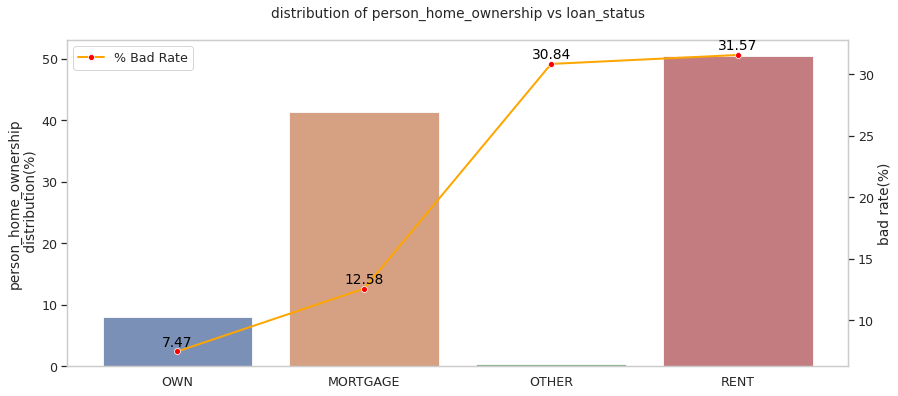

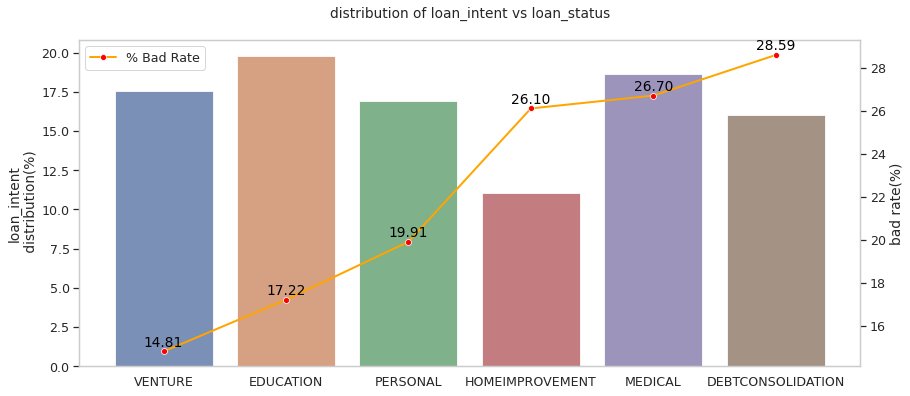

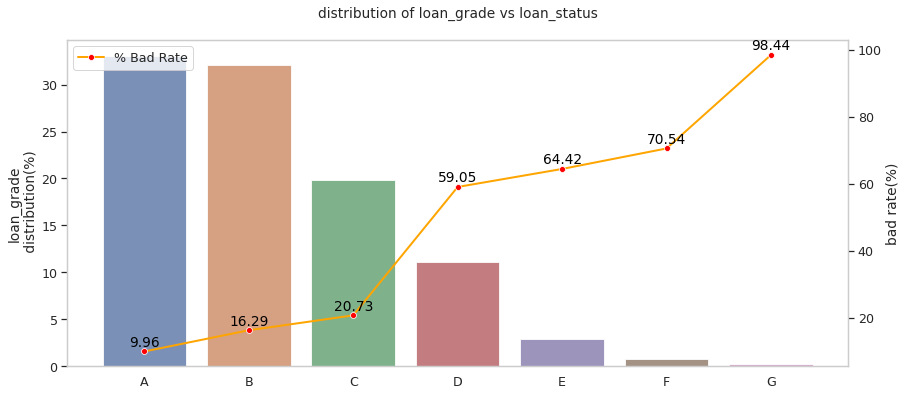

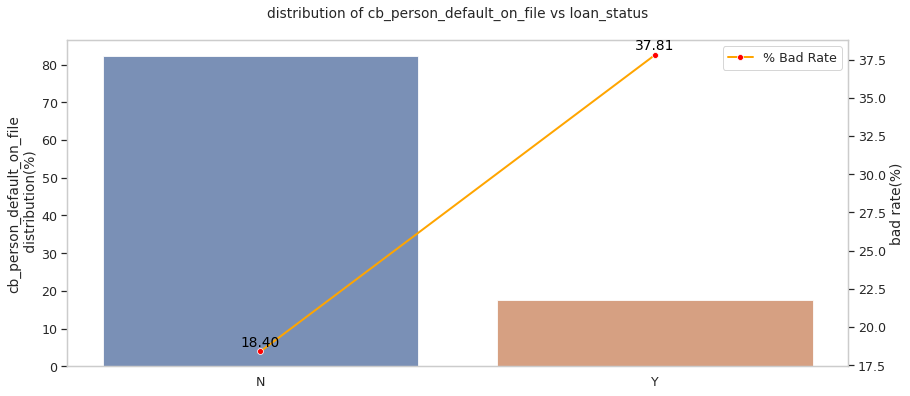

In [286]:
for i in findcolnum(df,["loan_status"])[0]:
    createbar(df,i,'loan_status',True)

**EDA on numerical Data**

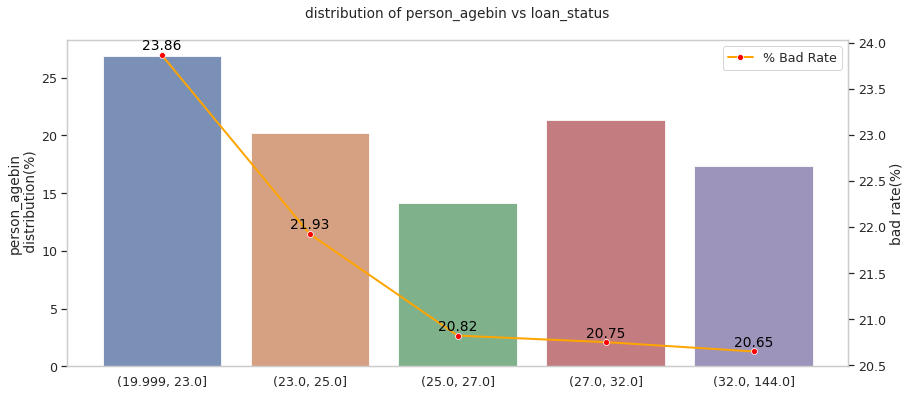

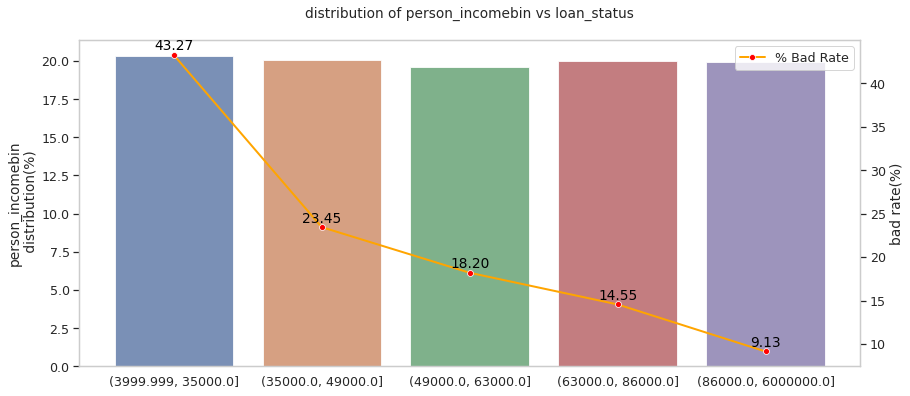

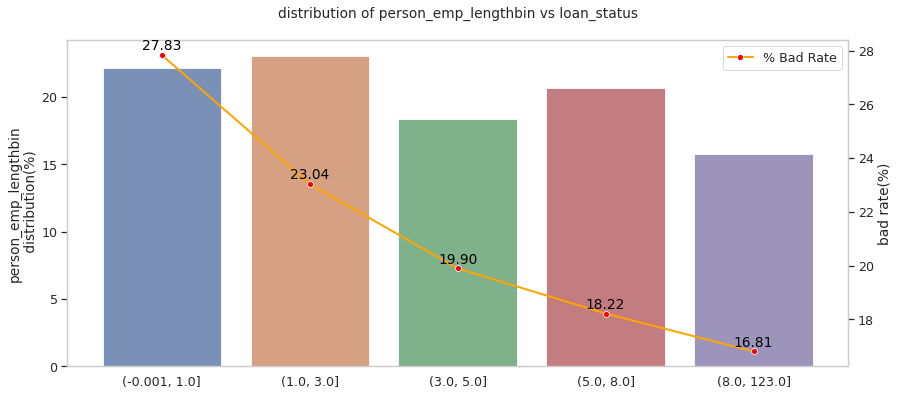

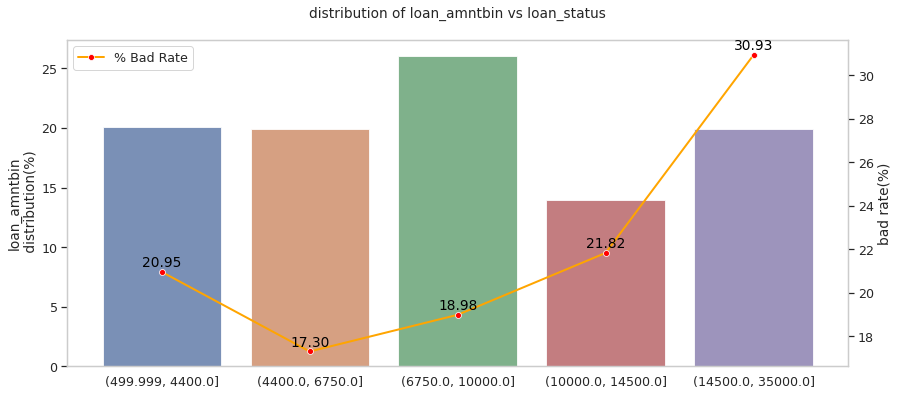

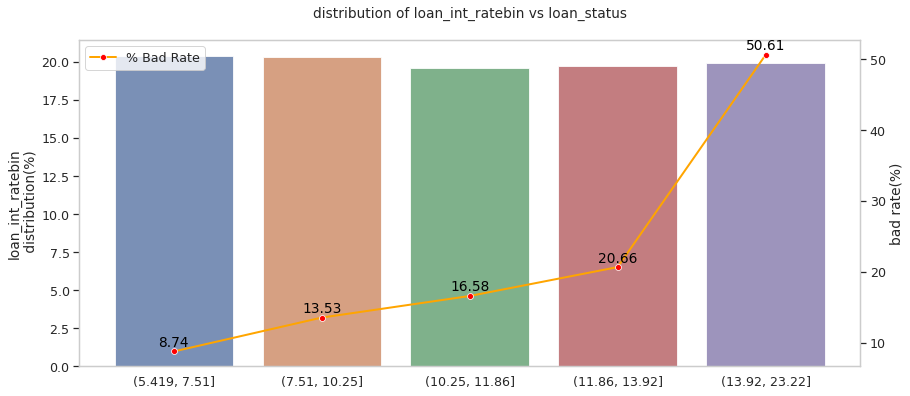

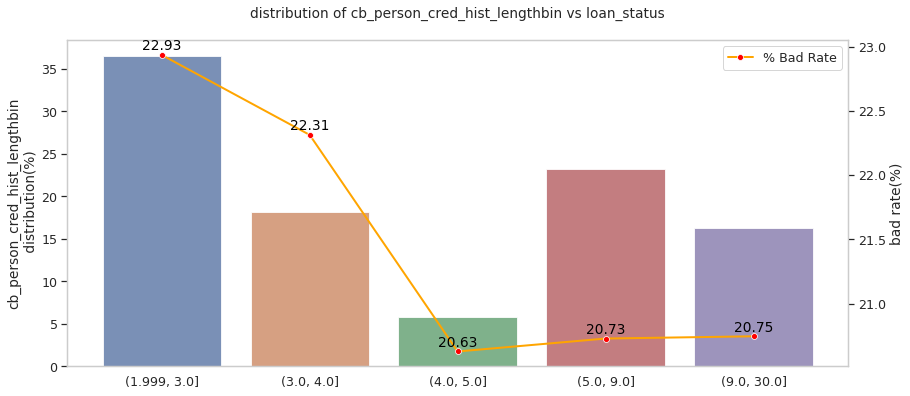

In [287]:
for i in findcolnum(df,["loan_status"])[1]:
    createbin(df,i,'loan_status',False)

# Data Cleaning

In [288]:
def fill_missing(df):
    for col in df.columns:
        if  df[col].dtypes == 'object' : 
            df[col] = df[col].fillna(value='Unidentified')
        elif (df[col].dtypes == 'int64') or ((df[col].dtypes == 'float64')):
            df[col] = df[col].fillna(df[col].median()) 
    return df

In [289]:
df = fill_missing(df)

# Feature engineering 

ในส่วนนี้จะเพิ่ม feature 3 ตัวคือ 
1. Debt Service Ratio (DSR)
2. WEIGHT OF EVIDENCE (WOE) 
3. INFORMATION VALUE (IV)

In [290]:
df['dsr'] = df.loan_amnt / df.person_income

<AxesSubplot:ylabel='Count'>

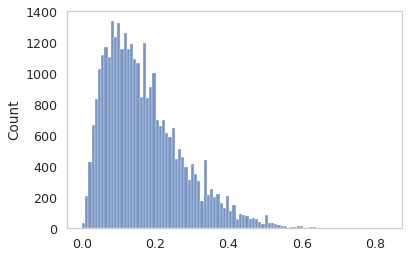

In [291]:
sns.histplot(df.loan_amnt / df.person_income)

**แบ่งกลุ่มตาม ความตั้งใจในการกู้**

In [292]:
df.groupby('loan_intent')[['dsr']].agg({'min','max','mean','median'})

dsr                              
                        min    median       max      mean
loan_intent                                              
DEBTCONSOLIDATION  0.004444  0.147494  0.711538  0.170800
EDUCATION          0.005464  0.148221  0.771154  0.170141
HOMEIMPROVEMENT    0.001282  0.143223  0.700000  0.165322
MEDICAL            0.005072  0.151515  0.777083  0.175195
PERSONAL           0.000789  0.147692  0.830000  0.169180
VENTURE            0.004143  0.147368  0.714286  0.170490

**ตรวจเช็คลูกค้าที่มีค่า dsr มากกว่า 0.7 หรือ มีแนวโน้มที่จะผ่อนจ่ายไม่ไหว**

In [293]:
df.loc[df.dsr > 0.7]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,cb_person_default_on_file,cb_person_cred_hist_length,dsr
customer_id,,,,,,,,,,,,
4c4563f7-d38f-43c9-9ace-159a38392ea7,24,18000,OWN,6.0,PERSONAL,A,13000,7.88,1,N,3,0.722222
63614e42-693c-4b3e-a1e7-4123125ace54,21,19500,MORTGAGE,0.0,EDUCATION,B,15000,9.64,1,N,2,0.769231
f820b47b-5d11-4ba0-8156-00d949a1e510,26,26000,RENT,10.0,EDUCATION,B,20050,9.76,1,N,2,0.771154
0ab3438d-8c0f-4fb2-a394-388e88a2835a,22,20000,MORTGAGE,0.0,PERSONAL,B,16600,9.76,1,N,3,0.830000
43b6fb9c-43af-44e9-bec0-c859b8004333,25,32004,MORTGAGE,3.0,PERSONAL,A,22750,6.17,0,N,4,0.710849
e994c1ab-3fb7-4978-9980-7e8ab8067b65,21,13000,RENT,0.0,DEBTCONSOLIDATION,C,9250,12.53,1,N,3,0.711538
c265fe71-6b84-4058-ac89-5d9c3f84bbbb,30,32004,RENT,1.0,PERSONAL,B,24250,11.12,1,N,5,0.757718
cdc87120-bfdf-4a9c-a17f-3594a610ab6b,32,12000,RENT,1.0,MEDICAL,A,9325,8.38,1,N,6,0.777083
47288db6-2b2a-4fd5-b0e1-dfff3585494c,33,10080,OWN,11.0,VENTURE,A,7200,6.03,1,N,8,0.714286


**จะเห็นว่าหาก dsr มากขึ้นเกินกว่า 0.25 จะมีแนวโน้มที่จะผิดชำระหนี้มากกว่า 50 %**

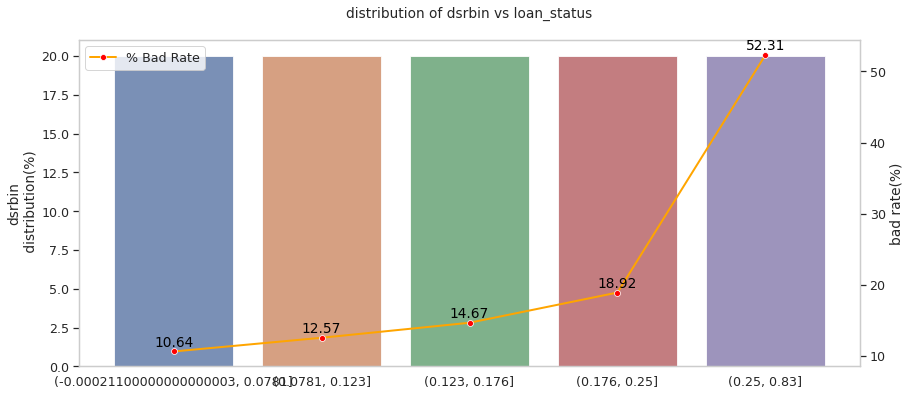

In [294]:
createbinqcus(df,'dsr','loan_status',False,5)

# WOE AND VI

ตามหลักการในการหาค่า WOE และ VI  feature ต่างๆนั้น ต้องถูกแปลงเป็น binning

**binning numerical data**

In [295]:
# binning numerical data
def binning_num(df):
    data = df.copy()
    for i in data[findcolnum(data,'')[1]]:
        if i == 'loan_status':
            continue
        data[i+'_bin'] = pd.qcut(data[i],5,duplicates='drop', precision=0).astype('object')
    return data
    

In [296]:
binning_num(df).head(2)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,cb_person_default_on_file,cb_person_cred_hist_length,dsr,person_age_bin,person_income_bin,person_emp_length_bin,loan_amnt_bin,loan_int_rate_bin,cb_person_cred_hist_length_bin,dsr_bin
customer_id,,,,,,,,,,,,,,,,,,,
616d39c7-4cca-4e2e-a65c-848a9543cfe1,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,Y,3,0.593220,"(19.0, 23.0]","(49000.0, 63000.0]","(8.0, 123.0]","(14500.0, 35000.0]","(13.6, 23.2]","(1.0, 3.0]","(0.3, 0.8]"
49d00b80-f7ec-41ec-8063-8cc32f384268,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,N,2,0.104167,"(19.0, 23.0]","(3999.0, 35000.0]","(3.0, 5.0]","(499.0, 4400.0]","(10.6, 11.5]","(1.0, 3.0]","(0.08, 0.1]"


In [297]:
binning_num(df).columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'dsr', 'person_age_bin',
       'person_income_bin', 'person_emp_length_bin', 'loan_amnt_bin',
       'loan_int_rate_bin', 'cb_person_cred_hist_length_bin', 'dsr_bin'],
      dtype='object')

In [298]:
df_withbin = binning_num(df)[[i for i in binning_num(df).columns if 'bin' in i]]

In [299]:
df_withbin['loan_status'] = df.loan_status
df_withbin.head(2)

,person_age_bin,person_income_bin,person_emp_length_bin,loan_amnt_bin,loan_int_rate_bin,cb_person_cred_hist_length_bin,dsr_bin,loan_status
customer_id,,,,,,,,
616d39c7-4cca-4e2e-a65c-848a9543cfe1,"(19.0, 23.0]","(49000.0, 63000.0]","(8.0, 123.0]","(14500.0, 35000.0]","(13.6, 23.2]","(1.0, 3.0]","(0.3, 0.8]",1
49d00b80-f7ec-41ec-8063-8cc32f384268,"(19.0, 23.0]","(3999.0, 35000.0]","(3.0, 5.0]","(499.0, 4400.0]","(10.6, 11.5]","(1.0, 3.0]","(0.08, 0.1]",0


**สร้างตาราง woe vi สำหรับ numerical data**

In [300]:
def createwoe(data):
    d = {}
    for i in data:
        if i =='loan_status':
            continue
        serie = pd.DataFrame(data.groupby(i)['loan_status'].agg({'count'})).reset_index()
        serie['count_bad'] = serie['count']*pd.DataFrame(data.groupby(i)['loan_status'].agg({'mean'})).reset_index()['mean']
        serie['count_good'] = serie['count'] - serie['count_bad']
        serie['dist_bad'] = serie['count_bad'] / serie['count_bad'].sum()
        serie['dist_good'] = serie['count_good'] / serie['count_good'].sum()
        serie['woe'] = np.log(serie.dist_bad/serie.dist_good)
        serie["iv"] = (serie.dist_bad-serie.dist_good)*np.log(serie.dist_bad/serie.dist_good)
        serie = serie.replace([np.inf, -np.inf], 0)
        d[i] = pd.DataFrame(serie)
        serie.rename(columns = {'woe':i+'_woe','iv':i+'_iv'} , inplace = True)
    return d
    


**ตาราง woe vi สำหรับ numerical data**


In [301]:
for i in createwoe(df_withbin):
    display(i,createwoe(df_withbin)[i])

'person_age_bin'

,person_age_bin,count,count_bad,count_good,dist_bad,dist_good,person_age_bin_woe,person_age_bin_iv
0,"(19.0, 23.0]",8766,2092.0,6674.0,0.294275,0.262013,0.116119,0.003746
1,"(23.0, 25.0]",6586,1444.0,5142.0,0.203123,0.201869,0.006193,0.000008
2,"(25.0, 27.0]",4615,961.0,3654.0,0.135181,0.143452,-0.059385,0.000491
3,"(27.0, 32.0]",6963,1445.0,5518.0,0.203263,0.216630,-0.063688,0.000851
4,"(32.0, 144.0]",5651,1167.0,4484.0,0.164158,0.176036,-0.069861,0.000830


'person_income_bin'

,person_income_bin,count,count_bad,count_good,dist_bad,dist_good,person_income_bin_woe,person_income_bin_iv
0,"(3999.0, 35000.0]",6630,2869.0,3761.0,0.403573,0.147652,1.005497,0.257327
1,"(35000.0, 49000.0]",6546,1535.0,5011.0,0.215923,0.196726,0.093113,0.001788
2,"(49000.0, 63000.0]",6397,1164.0,5233.0,0.163736,0.205441,-0.226904,0.009463
3,"(63000.0, 86000.0]",6515,948.0,5567.0,0.133352,0.218554,-0.494039,0.042093
4,"(86000.0, 6000000.0]",6493,593.0,5900.0,0.083415,0.231627,-1.021295,0.151368


'person_emp_length_bin'

,person_emp_length_bin,count,count_bad,count_good,dist_bad,dist_good,person_emp_length_bin_woe,person_emp_length_bin_iv
0,"(-1.0, 1.0]",7020,1954.0,5066.0,0.274863,0.198885,0.323545,0.024582
1,"(1.0, 3.0]",7305,1683.0,5622.0,0.236742,0.220713,0.070109,0.001124
2,"(3.0, 5.0]",6715,1440.0,5275.0,0.202560,0.207090,-0.022117,0.000100
3,"(5.0, 8.0]",6549,1193.0,5356.0,0.167815,0.210270,-0.225528,0.009575
4,"(8.0, 123.0]",4992,839.0,4153.0,0.118019,0.163042,-0.323157,0.014549


'loan_amnt_bin'

,loan_amnt_bin,count,count_bad,count_good,dist_bad,dist_good,loan_amnt_bin_woe,loan_amnt_bin_iv
0,"(499.0, 4400.0]",6543,1371.0,5172.0,0.192854,0.203046,-0.051501,5.249148e-04
1,"(4400.0, 6750.0]",6493,1123.0,5370.0,0.157969,0.210820,-0.288606,1.525310e-02
2,"(6750.0, 10000.0]",8493,1612.0,6881.0,0.226755,0.270140,-0.175070,7.595407e-03
3,"(10000.0, 14500.0]",4559,995.0,3564.0,0.139963,0.139918,0.000322,1.452507e-08
4,"(14500.0, 35000.0]",6493,2008.0,4485.0,0.282459,0.176076,0.472619,5.027870e-02


'loan_int_rate_bin'

,loan_int_rate_bin,count,count_bad,count_good,dist_bad,dist_good,loan_int_rate_bin_woe,loan_int_rate_bin_iv
0,"(5.300000000000001, 7.7]",6521,576.0,5945.0,0.081024,0.233394,-1.057980,0.161204
1,"(7.7, 10.6]",6523,925.0,5598.0,0.130117,0.219771,-0.524153,0.046992
2,"(10.6, 11.5]",6761,1242.0,5519.0,0.174708,0.216669,-0.215255,0.009032
3,"(11.5, 13.6]",6358,1264.0,5094.0,0.177803,0.199984,-0.117564,0.002608
4,"(13.6, 23.2]",6418,3102.0,3316.0,0.436348,0.130182,1.209506,0.370310


'cb_person_cred_hist_length_bin'

,cb_person_cred_hist_length_bin,count,count_bad,count_good,dist_bad,dist_good,cb_person_cred_hist_length_bin_woe,cb_person_cred_hist_length_bin_iv
0,"(1.0, 3.0]",11908,2731.0,9177.0,0.384161,0.360278,0.064186,0.001533
1,"(3.0, 4.0]",5925,1322.0,4603.0,0.185961,0.180708,0.028656,0.000151
2,"(4.0, 5.0]",1881,388.0,1493.0,0.054579,0.058613,-0.071319,0.000288
3,"(5.0, 9.0]",7555,1566.0,5989.0,0.220284,0.235121,-0.065182,0.000967
4,"(9.0, 30.0]",5312,1102.0,4210.0,0.155015,0.165280,-0.064118,0.000658


'dsr_bin'

,dsr_bin,count,count_bad,count_good,dist_bad,dist_good,dsr_bin_woe,dsr_bin_iv
0,"(-0.09920000000000001, 0.08]",6524,694.0,5830.0,0.097623,0.228879,-0.852082,0.111841
1,"(0.08, 0.1]",6510,818.0,5692.0,0.115065,0.223461,-0.663736,0.071946
2,"(0.1, 0.2]",6515,956.0,5559.0,0.134477,0.218240,-0.484197,0.040557
3,"(0.2, 0.3]",6517,1233.0,5284.0,0.173442,0.207443,-0.179015,0.006087
4,"(0.3, 0.8]",6515,3408.0,3107.0,0.479392,0.121977,1.368686,0.489189


In [302]:
createwoe(df_withbin)['person_age_bin'][['person_age_bin','person_age_bin_woe','person_age_bin_iv']]

,person_age_bin,person_age_bin_woe,person_age_bin_iv
0,"(19.0, 23.0]",0.116119,0.003746
1,"(23.0, 25.0]",0.006193,0.000008
2,"(25.0, 27.0]",-0.059385,0.000491
3,"(27.0, 32.0]",-0.063688,0.000851
4,"(32.0, 144.0]",-0.069861,0.000830


**ทำการ merge ค่าที่ได้จาก ตาราง woe ลงไปในตาราง df**

In [303]:
def merge_woe_iv(df):
    data = df.copy()
    for i in df_withbin:
        if(i == 'loan_status'):
            continue
        data = data.merge(createwoe(df_withbin)[i][[i,i+'_woe']],on = i)
    data.index = df.index
    return data

In [304]:
woe_df =  merge_woe_iv(df_withbin)[[i for i in merge_woe_iv(df_withbin) if ('bin' not in i ) or ('woe' in i) ]]

In [305]:
woe_df.head()

,loan_status,person_age_bin_woe,person_income_bin_woe,person_emp_length_bin_woe,loan_amnt_bin_woe,loan_int_rate_bin_woe,cb_person_cred_hist_length_bin_woe,dsr_bin_woe
customer_id,,,,,,,,
616d39c7-4cca-4e2e-a65c-848a9543cfe1,1,0.116119,-0.226904,-0.323157,0.472619,1.209506,0.064186,1.368686
49d00b80-f7ec-41ec-8063-8cc32f384268,1,0.006193,-0.226904,-0.323157,0.472619,1.209506,0.064186,1.368686
25172c7f-160a-44ac-b271-5833b7a679f6,1,0.006193,-0.226904,-0.323157,0.472619,1.209506,0.064186,1.368686
a8f721ac-9696-48b3-ae35-bc8b13592d26,0,0.006193,-0.226904,-0.323157,0.472619,1.209506,0.064186,1.368686
53be6c0c-0a33-41c1-a8d0-e9784b077f98,1,0.006193,-0.226904,-0.323157,0.472619,1.209506,0.064186,1.368686


**สร้างตาราง woe vi สำหรับ numerical data**


In [306]:
def binning_cat(df):
    data = df.copy()
    d = {}
    for i in df.columns:
        if i == 'loan_status':
            continue
        ser = pd.DataFrame(data.groupby([i]).size(), columns=['total'])
        ser['count_bad'] = data.groupby([i])['loan_status'].sum()
        ser['count_good'] = ser.total - ser.count_bad
        ser['dist_bad'] = ser['count_bad'] / ser['count_bad'].sum()
        ser['dist_good'] = ser['count_good'] / ser['count_good'].sum()
        ser[i+'_woe'] = np.log(ser.dist_bad/ser.dist_good)
        ser[i+"_iv"] = (ser.dist_bad-ser.dist_good)*np.log(ser.dist_bad/ser.dist_good)
        ser = ser.replace([np.inf, -np.inf], 0)
        ser = ser.reset_index()
        d[i] = ser
        #display(ser)
    return d
for i in binning_cat(pd.concat( [ df[findcolnum(df,'')[0]],df[['loan_status']] ] ,axis = 1)):
    display(binning_cat(pd.concat( [ df[findcolnum(df,'')[0]],df[['loan_status']] ] ,axis = 1))[i])

,person_home_ownership,total,count_bad,count_good,dist_bad,dist_good,person_home_ownership_woe,person_home_ownership_iv
0,MORTGAGE,13444,1691,11753,0.237867,0.461409,-0.662570,0.148112
1,OTHER,107,33,74,0.004642,0.002905,0.468661,0.000814
2,OWN,2584,193,2391,0.027149,0.093868,-1.240559,0.082769
3,RENT,16446,5192,11254,0.730342,0.441818,0.502614,0.145016


,loan_intent,total,count_bad,count_good,dist_bad,dist_good,loan_intent_woe,loan_intent_iv
0,DEBTCONSOLIDATION,5212,1490,3722,0.209593,0.146121,0.360733,0.022897
1,EDUCATION,6453,1111,5342,0.156281,0.209720,-0.294121,0.015718
2,HOMEIMPROVEMENT,3605,941,2664,0.132367,0.104585,0.235577,0.006545
3,MEDICAL,6071,1621,4450,0.228021,0.174702,0.266357,0.014202
4,PERSONAL,5521,1099,4422,0.154593,0.173602,-0.115973,0.002205
5,VENTURE,5719,847,4872,0.119145,0.191269,-0.473341,0.034139


,loan_grade,total,count_bad,count_good,dist_bad,dist_good,loan_grade_woe,loan_grade_iv
0,A,10777,1073,9704,0.150935,0.380967,-0.925861,0.212978
1,B,10451,1702,8749,0.239415,0.343475,-0.360917,0.037557
2,C,6458,1339,5119,0.188353,0.200966,-0.064818,0.000818
3,D,3626,2141,1485,0.301168,0.058299,1.642076,0.398808
4,E,964,621,343,0.087354,0.013466,1.869819,0.138158
5,F,241,170,71,0.023913,0.002787,2.149337,0.045407
6,G,64,63,1,0.008862,0.000039,5.419353,0.047814


,cb_person_default_on_file,total,count_bad,count_good,dist_bad,dist_good,cb_person_default_on_file_woe,cb_person_default_on_file_iv
0,N,26836,4937,21899,0.694472,0.859728,-0.213465,0.035276
1,Y,5745,2172,3573,0.305528,0.140272,0.778461,0.128646


In [307]:
def merge_cat(dff):
    for i in dff[findcolnum(dff,'')[0]]:
        dff = dff.merge(binning_cat(pd.concat( [ dff[findcolnum(dff,'')[0]],dff[['loan_status']] ] ,axis = 1))[i][[i,i+'_woe']] , on = i)
    return dff
addon_cat_woe = merge_cat(df).drop([i for i in merge_cat(df).columns if ('_woe') not in i ],axis = 1)

In [308]:
addon_cat_woe.head()

,person_home_ownership_woe,loan_intent_woe,loan_grade_woe,cb_person_default_on_file_woe
0,0.502614,-0.115973,1.642076,0.778461
1,0.502614,-0.115973,1.642076,0.778461
2,0.502614,-0.115973,1.642076,0.778461
3,0.502614,-0.115973,1.642076,0.778461
4,0.502614,-0.115973,1.642076,0.778461


**รวมตาราง woe vi สำหรับ ทั้ง numerical และ catergorical เข้าด้วยกันเป็นตัวแปรชื่อว่า full_woe**


In [309]:
full_woe = pd.concat([woe_df.reset_index(),addon_cat_woe],axis = 1)
full_woe = full_woe.loc[:,~full_woe.columns.duplicated()].copy()

In [310]:
full_woe.head()

,customer_id,loan_status,person_age_bin_woe,person_income_bin_woe,person_emp_length_bin_woe,loan_amnt_bin_woe,loan_int_rate_bin_woe,cb_person_cred_hist_length_bin_woe,dsr_bin_woe,person_home_ownership_woe,loan_intent_woe,loan_grade_woe,cb_person_default_on_file_woe
0,616d39c7-4cca-4e2e-a65c-848a9543cfe1,1,0.116119,-0.226904,-0.323157,0.472619,1.209506,0.064186,1.368686,0.502614,-0.115973,1.642076,0.778461
1,49d00b80-f7ec-41ec-8063-8cc32f384268,1,0.006193,-0.226904,-0.323157,0.472619,1.209506,0.064186,1.368686,0.502614,-0.115973,1.642076,0.778461
2,25172c7f-160a-44ac-b271-5833b7a679f6,1,0.006193,-0.226904,-0.323157,0.472619,1.209506,0.064186,1.368686,0.502614,-0.115973,1.642076,0.778461
3,a8f721ac-9696-48b3-ae35-bc8b13592d26,0,0.006193,-0.226904,-0.323157,0.472619,1.209506,0.064186,1.368686,0.502614,-0.115973,1.642076,0.778461
4,53be6c0c-0a33-41c1-a8d0-e9784b077f98,1,0.006193,-0.226904,-0.323157,0.472619,1.209506,0.064186,1.368686,0.502614,-0.115973,1.642076,0.778461


**คำนวน ค่า IV ของแต่ละ feater ตารางด้านล่างจะแสดง predictive power ของแต่ละ feature เพื่อใช้ในการประกอบการตัดสินใจ**

In [311]:
iv_dic = createwoe(df_withbin)
l = {}
for i in iv_dic.keys():
    l[i] = iv_dic[i].iloc[:,-1].sum()
iv_dic2 = binning_cat(pd.concat( [ df[findcolnum(df,'')[0]],df[['loan_status']] ] ,axis = 1))
for i in iv_dic2.keys():
    l[i] = iv_dic2[i].iloc[:,-1].sum()
ivtable = pd.DataFrame(pd.Series(l).sort_values(ascending = False)).rename(columns = {0:'IV'})
ivtable

,IV
loan_grade,0.881539
dsr_bin,0.719621
loan_int_rate_bin,0.590146
person_income_bin,0.462039
person_home_ownership,0.376710
cb_person_default_on_file,0.163922
loan_intent,0.095705
loan_amnt_bin,0.073652
person_emp_length_bin,0.049930
person_age_bin,0.005926


**กำหนด thereshold ของค่า IV เพื่อให้สื่อสารได้ง่ายยิ่งขึ้น**

In [312]:
ivtable['predictive_power'] = 'not useful'
ivtable.loc[((ivtable['IV'] > 0.02) & (ivtable['IV'] <= 0.1) ),['predictive_power']] = 'Weak'
ivtable.loc[((ivtable['IV'] > 0.1) & (ivtable['IV'] <= 0.3) ),['predictive_power']] = 'Medium'
ivtable.loc[((ivtable['IV'] > 0.3) & (ivtable['IV'] <= 0.5) ),['predictive_power']] = 'Strong'
ivtable.loc[((ivtable['IV'] > 0.5) ),['predictive_power']] = 'Suspicious'
ivtable

,IV,predictive_power
loan_grade,0.881539,Suspicious
dsr_bin,0.719621,Suspicious
loan_int_rate_bin,0.590146,Suspicious
person_income_bin,0.462039,Strong
person_home_ownership,0.376710,Strong
cb_person_default_on_file,0.163922,Medium
loan_intent,0.095705,Weak
loan_amnt_bin,0.073652,Weak
person_emp_length_bin,0.049930,Weak
person_age_bin,0.005926,not useful


<AxesSubplot:>

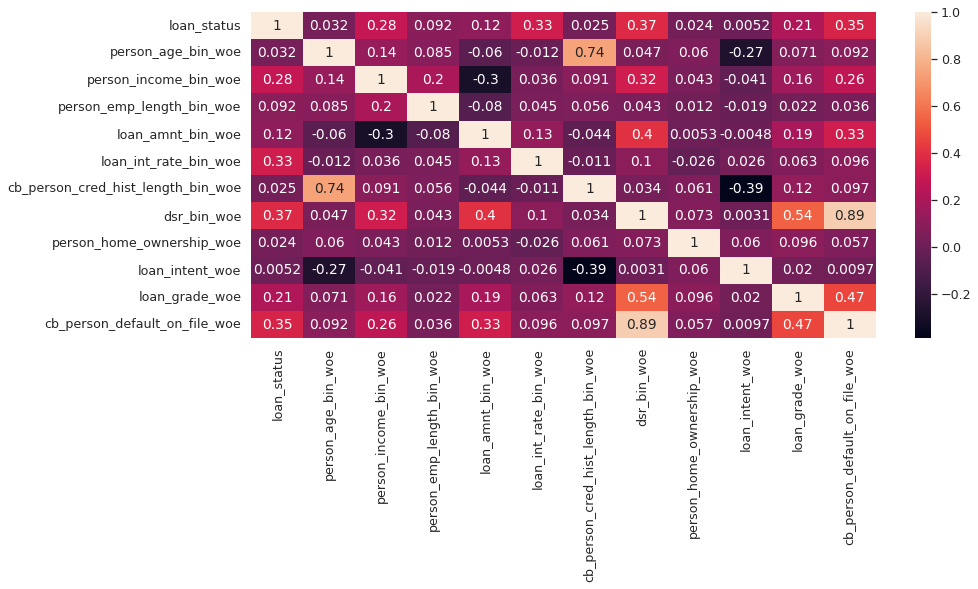

In [329]:
plt.figure(figsize = (14,6))
sns.heatmap(full_woe.drop(['customer_id'],axis = 1).corr(),annot = True)

# Data Modeling
**ในส่วนนี้จะใช้ model logistic regression**

In [314]:
X = full_woe.drop(['loan_status','customer_id'],axis = 1)
y = full_woe.loan_status
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state = 42 , test_size = 0.33
                                                 ,stratify = full_woe.loan_status)

In [315]:
import statsmodels.api as sm

In [316]:
import statsmodels.api as sm
model = sm.Logit(y_train, sm.add_constant(x_train)).fit(disp=True, 
                                                        maxiter=1000,
                                                        intercept=True)

model.summary()


Optimization terminated successfully.
         Current function value: 0.389977
         Iterations 7


/opt/conda/lib/python3.7/site-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol. The list of unsupported keyword arguments passed include: intercept. After release 0.14, this will raise.
  FutureWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                21829
Model:                          Logit   Df Residuals:                    21817
Method:                           MLE   Df Model:                           11
Date:                Tue, 11 Apr 2023   Pseudo R-squ.:                  0.2566
Time:                        14:48:36   Log-Likelihood:                -8512.8
converged:                       True   LL-Null:                       -11452.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.3271      0.021    -64.095      0.000      -1.368      -1.286
person_age_bin_woe                    -0.2070      0.378     -0.547      0.584      -0.949       0.535
person_income_bin_woe                  1.0016      0.036     28.212      0.000       0.932       1.071
person_emp_length_bin_woe              0.6003      0.089      6.739      0.000       0.426       0.775
loan_amnt_bin_woe                      0.8584      0.093      9.244      0.000       0.676       1.040
loan_int_rate_bin_woe                  1.1064      0.026     43.384      0.000       1.056       1.156
cb_person_cred_hist_length_bin_woe    -0.2382      0.523     -0.455      0.649      -1.263       0.787
dsr_bin_woe                            0.5294      0.057      9.312      0.000       0.418       0.641
person_home_ownership_woe             -0.0009      0.031     -0.029      0.977      -0.061       0.059
loan_intent_woe                       -0.0070      0.066     -0.105      0.916      -0.137       0.123
loan_grade_woe                         0.0608      0.025      2.383      0.017       0.011       0.111
cb_person_default_on_file_woe          0.4428      0.097      4.548      0.000       0.252       0.634
======================================================================================================
"""

In [317]:
results_as_html = model.summary().tables[1].as_html()
summary = pd.read_html(results_as_html, header=0, index_col=0)[0]
summary['Feature'] = summary.index
summary = summary.reset_index(drop=True)
summary['Feature'] = summary['Feature'].str.replace('woe_', '')
summary = summary.set_index(['Feature'], drop=True)
summary

,coef,std err,z,P>|z|,[0.025,0.975]
Feature,,,,,,
const,-1.3271,0.021,-64.095,0.000,-1.368,-1.286
person_age_bin_woe,-0.2070,0.378,-0.547,0.584,-0.949,0.535
person_income_bin_woe,1.0016,0.036,28.212,0.000,0.932,1.071
person_emp_length_bin_woe,0.6003,0.089,6.739,0.000,0.426,0.775
loan_amnt_bin_woe,0.8584,0.093,9.244,0.000,0.676,1.040
loan_int_rate_bin_woe,1.1064,0.026,43.384,0.000,1.056,1.156
cb_person_cred_hist_length_bin_woe,-0.2382,0.523,-0.455,0.649,-1.263,0.787
dsr_bin_woe,0.5294,0.057,9.312,0.000,0.418,0.641
person_home_ownership_woe,-0.0009,0.031,-0.029,0.977,-0.061,0.059


In [318]:
def train_model(X_train, y_train):

    ### Fit logistic regression ###
    model = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=True, 
                                                            maxiter=1000,
                                                            intercept=True)
    
    ### Generate model summary ###
    results_as_html = model.summary().tables[1].as_html()
    summary = pd.read_html(results_as_html, header=0, index_col=0)[0]
    summary['Feature'] = summary.index
    summary = summary.reset_index(drop=True)
    summary['Feature'] = summary['Feature'].str.replace('woe_', '')
    summary = summary.set_index(['Feature'], drop=True)

    return model, summary

In [319]:
lr, lr_summary = train_model(x_train, y_train)

Optimization terminated successfully.
         Current function value: 0.389977
         Iterations 7


/opt/conda/lib/python3.7/site-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol. The list of unsupported keyword arguments passed include: intercept. After release 0.14, this will raise.
  FutureWarning


In [320]:
y_pred_train = lr.predict(sm.add_constant(x_train))
y_pred_test = lr.predict(sm.add_constant(x_test))

y_pred_test

11091    0.112403
15442    0.063748
25339    0.064549
26586    0.079971
477      0.890129
           ...   
5654     0.259981
2744     0.854251
18788    0.066717
19747    0.204678
24075    0.268606
Length: 10752, dtype: float64

In [321]:
lr_summary

,coef,std err,z,P>|z|,[0.025,0.975]
Feature,,,,,,
const,-1.3271,0.021,-64.095,0.000,-1.368,-1.286
person_age_bin_woe,-0.2070,0.378,-0.547,0.584,-0.949,0.535
person_income_bin_woe,1.0016,0.036,28.212,0.000,0.932,1.071
person_emp_length_bin_woe,0.6003,0.089,6.739,0.000,0.426,0.775
loan_amnt_bin_woe,0.8584,0.093,9.244,0.000,0.676,1.040
loan_int_rate_bin_woe,1.1064,0.026,43.384,0.000,1.056,1.156
cb_person_cred_hist_length_bin_woe,-0.2382,0.523,-0.455,0.649,-1.263,0.787
dsr_bin_woe,0.5294,0.057,9.312,0.000,0.418,0.641
person_home_ownership_woe,-0.0009,0.031,-0.029,0.977,-0.061,0.059


In [322]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [323]:
features = full_woe.drop(['customer_id','loan_status'],axis = 1).copy()
features.columns = features.columns.str.replace('woe_', '')
features = features.assign(const=1)
features

vif = pd.DataFrame()
vif["Feature"] = features.columns
vif["VIF Factor"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif

,Feature,VIF Factor
0,person_age_bin_woe,2.267745
1,person_income_bin_woe,1.565106
2,person_emp_length_bin_woe,1.047467
3,loan_amnt_bin_woe,1.634868
4,loan_int_rate_bin_woe,1.029072
5,cb_person_cred_hist_length_bin_woe,2.525919
6,dsr_bin_woe,6.679753
7,person_home_ownership_woe,1.022808
8,loan_intent_woe,1.206193
9,loan_grade_woe,1.471743


# EVALUATION

In [324]:
mod = RandomForestClassifier()
mod.fit(x_train,y_train)
mod.predict(x_test)
printscore(mod.predict(x_test),y_test,'RandomForest')

,RandomForest
roc_auc_score,0.7181581557375041
f1_score,0.5219012115563839
recall_score,0.5755395683453237
precision_score,0.4774083546462063
accuracy_score,0.8091517857142857


In [325]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, classification_report

In [326]:
def roc_gini(y, y_pred_proba):
    assert y.shape == y_pred_proba.shape
    fpr, tpr, _ = metrics.roc_curve(y, y_pred_proba)
    auc = metrics.roc_auc_score(y, y_pred_proba)
    gini = (2 * auc - 1)*100

    fig = plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='C0', label='%s AUC = %0.4f, Gini = %0.2f' % ('Model: ', auc,  gini), 
           linewidth=2.5)
    plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--', linewidth=2)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right',fontsize='small')
    plt.grid(False)
    plt.show()

Training set


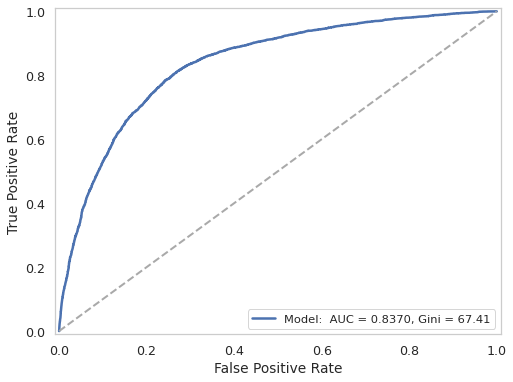

Test set


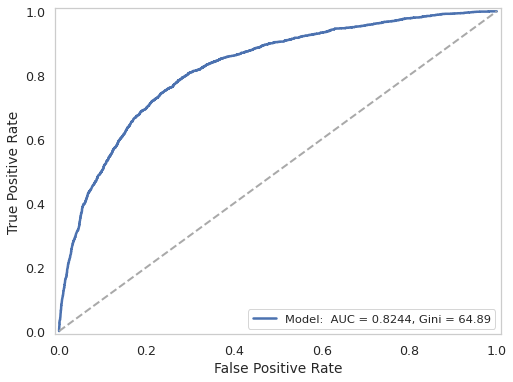

In [327]:
print('Training set')
roc_gini(y_train.values, y_pred_train)
    
print('Test set')
roc_gini(y_test.values, y_pred_test)